# Import libraries

In [1]:
'''#import libraries
%matplotlib widget
import trackpy as tp
tp.quiet()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

import sdt
from sdt import io, multicolor, brightness, roi
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import pims
from scipy.ndimage import gaussian_filter
import matplotlib.patches as patches
from glob import glob
import copy
from sdt import nbui, io
import traitlets
import ipywidgets
import itertools'''

'#import libraries\n%matplotlib widget\nimport trackpy as tp\ntp.quiet()\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom mpl_toolkits.mplot3d import Axes3D\nimport matplotlib as mpl\n\nimport sdt\nfrom sdt import io, multicolor, brightness, roi\nfrom mpl_toolkits.mplot3d import Axes3D\nimport scipy.io\nimport pims\nfrom scipy.ndimage import gaussian_filter\nimport matplotlib.patches as patches\nfrom glob import glob\nimport copy\nfrom sdt import nbui, io\nimport traitlets\nimport ipywidgets\nimport itertools'

In [2]:
#import libraries
%matplotlib widget
from glob import glob
import pims
import matplotlib.pyplot as plt
import sdt
from sdt import nbui, roi, multicolor, image 
import math

import ipywidgets
import os
import numpy as np
import pandas as pd
import pickle
from tifffile import TiffFile, TiffWriter
import re
from scipy.io import loadmat # to load matlab .mat files

# for the GPU Fit
import importlib
import MLEGPU
importlib.reload(MLEGPU)
from MLEGPU import MLEFitLMGPU # import module

# Import STORM video

## input (specify folder path)

In [3]:
# Define the directory where files are stored
directory = os.getcwd()

# Define the regex pattern
pattern = re.compile(r'def[0-9]+_n1[0-9]+\.mat')

# List all files in the directory
files = os.listdir(directory)

# Filter files that match the pattern
matching_files = [f for f in files if pattern.match(f)]
matching_files.sort()

matching_paths = [directory+'/'+f for f in matching_files]
# Output the list of matching filenames
print(matching_files)
print(matching_paths)


#import storm videos (tif)
pth = directory
filenames = sorted(glob(f"{pth}/*.stk"))

print(filenames)

['def600_n133.mat']
['/mnt/d/Simon Jaritz/mlefitgpu-main/def600_n133.mat']
['/mnt/d/Simon Jaritz/mlefitgpu-main/2023_02_16_Nr1_ROI1_STORM_1_RICMdSTORMred.stk']


In [4]:
def crop(img, x, y, size):
    return img[x:x+size, y:y+size]

def imchange(change=None):
    loc_r_ui.input = loc_r_imsel.output

## run

In [11]:
# open images using tifffile

with TiffWriter("out.tif", bigtiff=True) as wr:
    for f in filenames:
        with TiffFile(f) as rd:
            imgs = rd.asarray()
            for i in imgs:
                wr.write(i, contiguous=True) # contiguous only when frame sizes match


Frame([[278, 346, 238, ..., 243, 236, 286],
       [225, 243, 318, ..., 227, 220, 222],
       [270, 287, 299, ..., 271, 269, 240],
       ...,
       [420, 503, 458, ..., 213, 186, 300],
       [424, 413, 473, ..., 283, 255, 254],
       [560, 536, 360, ..., 248, 257, 267]], dtype=uint16)
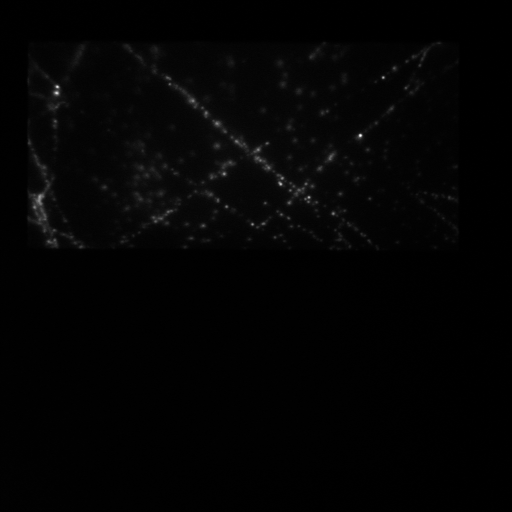

In [12]:
vid = [pims.open("out.tif")]
vid[0][1]

# ROI management

## input (define roi)

In [13]:
#define roi
roiv = roi.ROI((128,0), size=(256, 256)) # (128, 0) for red channel, (128, 256) for green channel

# default:
# roiv = roi.ROI((128, 0), size=(256, 256)) # (128, 0) for red channel, (128, 256) for green channel

## run

In [14]:
#save roi
with open(f'{pth}/roiv.pkl', 'wb') as file:
    pickle.dump(roiv, file)

In [15]:
#load roi
with open(f'{pth}/roiv.pkl', 'rb') as f:
    roiv = pickle.load(f)

Frame([[282, 217, 202, ..., 221, 218, 208],
       [272, 267, 272, ..., 246, 225, 264],
       [252, 237, 224, ..., 222, 266, 326],
       ...,
       [251, 230, 231, ..., 241, 201, 205],
       [210, 225, 250, ..., 207, 190, 208],
       [380, 274, 238, ..., 178, 211, 237]], dtype=uint16)
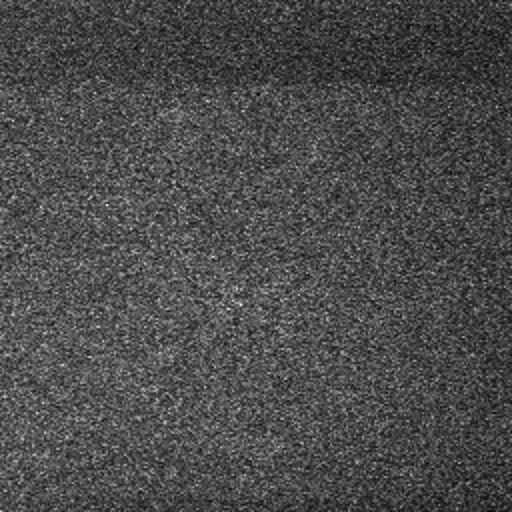

In [16]:
# crop
vid=[roiv(i) for i in vid]
vid[0][0]

Frame([[282, 217, 202, ..., 221, 218, 208],
       [272, 267, 272, ..., 246, 225, 264],
       [252, 237, 224, ..., 222, 266, 326],
       ...,
       [251, 230, 231, ..., 241, 201, 205],
       [210, 225, 250, ..., 207, 190, 208],
       [380, 274, 238, ..., 178, 211, 237]], dtype=uint16)
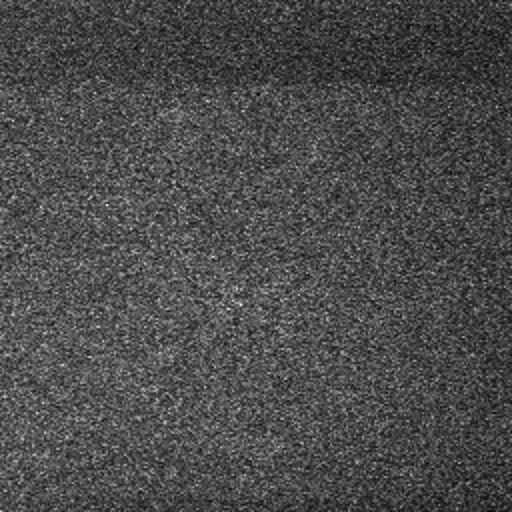

In [17]:
vid[0][0]

# Define Prelocs

In [18]:
### locator app
loc_r_ui = nbui.Locator()
loc_r_imsel = nbui.ImageSelector({n: i for n, i in zip(filenames, vid)})
loc_r_imsel.observe(imchange, "output")
imchange()
loc_r_ui.image_display.auto_scale()
ipywidgets.VBox([loc_r_imsel, loc_r_ui])

/home/bomberman/miniconda3/lib/python3.11/site-packages/sdt/nbui/locator.py:306: UserWarning: Turning off matplotlib's interactive mode as it is not compatible with this.
  warnings.warn("Turning off matplotlib's interactive mode as it "


In [19]:
matching_paths

['/mnt/d/Simon Jaritz/mlefitgpu-main/def600_n133.mat']

# Cropping and GPU Fit

In [20]:
for k in range(len(matching_paths)):
    print(int(k/len(matching_paths)*100),'% done')
    defocus = matching_files[k][:-4]
    pthpsf = matching_paths[k]
    prl = loadmat(pthpsf) # load datafile from matlab app
    
    psf = prl["PSF"][0,0][8] # load the psf 
    nx_psf,ny_psf,nz_psf = psf.shape # dimensions of the psf
    os = prl["PSF"][0,0][7][0,0] 
    QE = prl["PSF"][0,0][9][0,0][2][0,0] 
    baseline = prl["PSF"][0,0][9][0,0][3][0,0]
    amp = prl["PSF"][0,0][9][0,0][4][0,0]
    
    
    
    # 2D localization
    # batch_func for multiple images, locate_func for single frame
    preloc = [loc_r_ui.batch_func(i, **loc_r_ui.options) for i in vid]
    
    #save preloc parameters as pkl
    with open(f'{directory}/preloc_par_{defocus}.pkl', 'wb') as file:
        pickle.dump(loc_r_ui.options, file)
    
    
    # filter prelocs
    
    # filter out close neighbors
    min_dis=10 # pixels, default is 10 px
    sdt.spatial.has_near_neighbor(preloc[0], min_dis)
    
    
    # filter out molecules close to edges
    preloc[0]=preloc[0][(preloc[0]['x']>nx_psf/2) & (preloc[0]['x']<vid[0][0].shape[1]-nx_psf/2)]
    preloc[0]=preloc[0][(preloc[0]['y']>nx_psf/2) & (preloc[0]['y']<vid[0][0].shape[1]-nx_psf/2)]
    
    preloc[0]=preloc[0][preloc[0]['has_neighbor']==0]
    preloc[0]=preloc[0].reset_index()
    
    # save prelocs
    with open(f'{directory}/prelocs_{defocus}.pkl', 'wb') as file:
        pickle.dump(preloc, file)
    
    # load prelocs
    with open(f'{directory}/prelocs_{defocus}.pkl', 'rb') as f:
        preloc = pickle.load(f)
        
#     ########################
#     # Crop individual SM images

    psf_size=int(nx_psf/os)
    SMim=np.zeros((len(preloc[0]), psf_size, psf_size))
    for index, row in preloc[0].iterrows():
        SMim[index,:,:] = crop(vid[0][int(row['frame'])], 
                               math.ceil(row["y"]-psf_size/2), 
                               math.ceil(row["x"]-psf_size/2), psf_size)
   
    
    M = SMim.astype(np.float32)
    M = (M-baseline)/300*amp/QE
    M[M<0] = 0
    
#     # # # # # # # # # # # # # # # # # # # # 
#     # 3D fitting GPU
    n_img,nx,ny = M.shape
    
    # define initial estimates for the fit parameters
    
    x0_start = np.zeros(n_img,dtype=np.float32)
    y0_start = np.zeros(n_img,dtype=np.float32)
    z0_start = np.zeros(n_img,dtype=np.float32)
    BG_start = np.min(M,axis=(1,2))
    NP_start = np.sum(M,axis=(1,2))-(BG_start*nx*ny)
    
    
    # define bounds on the fit parameters
    x0min,x0max = -3,3
    y0min,y0max = -3,3
    z0min,z0max = int(np.floor(-nz_psf/2)), int(np.ceil(nz_psf/2))  #-16,16 #change based on PSF
    BGmin,BGmax = 0,1e5
    NPmin,NPmax = 0,1e7
    
    bounds = ((x0min,x0max),
              (y0min,y0max),
              (z0min,z0max),
              (BGmin,BGmax),
              (NPmin,NPmax),
              )
    
    ''' 
    the batch_size is the number of images, which are processed in parallel
    when the total number of images (here n_img) is too large to fit in the GPU memory 
    we can choose a batch_size < n_img, which only loads a number of batch_size images at a time
    '''
    
    batch_size = n_img 
    batch_size = 10000
    batch_size,n_img, batch_size//n_img
    
    '''
    MLEFitLMGPU takes arguments:
    grid: size of the measured images
    grid_psf: size of the psf used. has to be (os * nx, os * ny, nz_psf).
    os: oversampling factor used
    batch_size: number of batches processed in parallel
    '''
    
    MLE_LM = MLEFitLMGPU(grid=(nx,ny),
                         grid_psf=(nx_psf,ny_psf,nz_psf),os=os,batch_size=batch_size)
    
    
    
    # set psf
    MLE_LM.set_psf(psf)
    
    '''
    fit the measurements
    
    x0_start, y0_start, z0_start, BG_start, NP_start: initial estimates of fit parameters, all with shapes (n_img) 
    M: measurement images with shapes (n_img, nx, ny)
    bounds: tuple of tuples ((x0min, x0max), (y0min, y0max), ...)
    maxiter: maximum number of iterations 
    
    returns fit_results: dict with keys 'x0','y0','z0','BG','NP','chi2'. 'chi2' is the LLR 
    
    '''
    fit_results = MLE_LM.fit(x0_start = x0_start, 
                             y0_start = y0_start,
                             z0_start = z0_start,
                             BG_start = BG_start,
                             NP_start = NP_start,
                             M = M,
                             bounds = bounds,
                             maxiter=100) #LLR should be converged
    
    x0_result = fit_results['x0']
    y0_result = fit_results['y0']
    z0_result = fit_results['z0']
    BG_result = fit_results['BG']
    NP_result = fit_results['NP']
    chi2_result = fit_results['chi2']
    
    ux = 1e9*prl["PSF"][0,0][5]   #nm
    uz = 1e9*prl["PSF"][0,0][6]   #nm
    ux,uz = ux[0,0],uz[0,0]
    
    results = {
        'id'                : preloc[0].index,
        'frame'             : preloc[0]['frame'].values,
        'x [nm]'            : ux*(np.round(preloc[0]['x'].values) + fit_results['x0']),
        'y [nm]'            : ux*(np.round(preloc[0]['y'].values) + fit_results['y0']),
        'z [nm]'            : uz*(nz_psf / 2 
                                  - fit_results['z0'] ),
        'signal / photons'  : NP_result,
        'BG / photons'      : BG_result,
        'LLR'               : chi2_result,
    }
    
    preliminary_results = pd.DataFrame(results)
    preliminary_results.to_csv(f'preloc_results_{defocus}.csv')

0 % done


In [21]:
print('script is ready')

script is ready
